## Power analysis for the detection of EMG contaminated EEG epochs having a duration of 2 seconds

Necessary packages to import

In [178]:
from tkinter import filedialog
import tkinter as tk
import numpy as np
import mne
import EegPreprocessor as preprocessor
import scratch as testing
import matplotlib.pyplot as plt

Necessary functions for initial preprocessing like removal of line noise, filtering,
average referencing

In [38]:
#Preprocessing file
print(__doc__)


DEFAULT_EOG = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8']


def get_raw_data_file_path():
    root = tk.Tk()
    root.withdraw()
    data_file_path  = filedialog.askopenfilename()
    return data_file_path


#Channel position function for Biosemi machine
def load_biosemi_montage(string = 'biosemi64'):
    montage = mne.channels.make_standard_montage(string)
    return montage


#Loading the raw data
def load_raw_data(filepath, montage, eog = DEFAULT_EOG):
    raw = mne.io.read_raw_bdf(filepath, montage, eog, preload =True)
    return raw


def preprocess_raw_data():
    print("Please enter the raw data file")
    filepath = get_raw_data_file_path()    
    montage = load_biosemi_montage()
    raw = load_raw_data(filepath, montage)        
    
#High pass filtering of data
    raw.filter(0.1, 100.0, fir_design='firwin')
    
#Notch fitering to remove the line noise
    raw.notch_filter(np.arange(60, 241, 60), fir_design='firwin')
    
#Setting the average EEG reference
    raw.set_eeg_reference('average', projection=False)
    
    return raw



Automatically created module for IPython interactive environment


Calling the preprocessing of the raw data function

In [39]:
raw = preprocess_raw_data()#Done

Please enter the raw data file
Extracting EDF parameters from C:\Users\J_CHOWD\Desktop\Project_CAE\data_format_BDF\DATA_bdf_format\BDF\2019-05-03-suject-01-realTask_merged_One_fourth.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 705535  =      0.000 ...  1377.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 16897 samples (33.002 sec)



<ipython-input-38-4620b7da894d>:23: DeprecationWarning: The `montage` parameter from `read_raw_edf` is deprecated and will be removed  in version 0.20. Use  raw.set_montage(montage) instead.
  raw = mne.io.read_raw_bdf(filepath, montage, eog, preload =True)


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3379 samples (6.600 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


In [223]:
def final_band_power(raw,channel,N,fs,tmin=None, tmax=None,epoch_time=2):
    """
    raw = Mne.raw object
    picks = no. of channels to include, type must be string
    N = No. of samples for FFT algorithm
    fs = sampling frequecy 
    tmin = starting time of the trials
    tmax = end time of the trials
    epoch_time = duration of the epoch by default 2 seconds
    """
    raw = raw.pick(picks=channel)
    
    if (tmin==None and tmax == None):
        n_epochs = 100
    else:
        n_epochs = int((tmax-tmin)/epoch_time)
    
    data = raw.get_data()
    data = data/1e-06 #Scaling the input data from volt unit to microvolt unit
    n_channels = len(raw.ch_names)
    epoch_power_45_70Hz = np.zeros((n_channels,n_epochs,1),dtype = 'float')
    
    for chan in range(n_channels):
        for epoch in range(n_epochs):
            epoch_data = data[chan, N*epoch:N*(epoch+1)] #Formation of 2s epoch data with N samples
            epoch_data = np.fft.fft(epoch_data, N)
            #calculation of k in the formula
            k_lower = int(45*(N/fs)) # Forcing these to integers otherwise index error problem will pop up 
            k_upper = int(70*(N/fs))
            temp = np.zeros((50),dtype='float')
            for k in range(k_lower, k_upper):
                val = (np.abs(epoch_data[k_lower])) ** 2 + (np.abs(epoch_data[N - k_lower])) ** 2
                temp[k-90] = val
            
            power_45_70Hz = (1/N**2)*sum(temp)
            epoch_power_45_70Hz[chan,epoch] = power_45_70Hz
            
    return epoch_power_45_70Hz

Setting the raw objects according to the primary electrodes and their 5 adjacent channels
highly affected by frontalis and temporalis muscle. 


In [224]:
primary_raw = raw.copy()
primary_picks = ['AF7','AF8','FT7','FT8']
primary_power_45_70Hz = final_band_power(primary_raw, channel = primary_picks, N=1024,fs=512)
primary_raw = primary_raw.pick(picks = primary_picks)

AF7_raw = raw.copy()
AF7_picks = ['Fp1', 'AF3', 'F3', 'F5', 'F7']
AF7_power_45_70Hz = final_band_power(AF7_raw, channel = AF7_picks, N=1024,fs=512)
#AF7_raw = AF7_raw.pick(picks = AF7_picks)

AF8_raw = raw.copy()
AF8_picks = ['Fp2', 'AF4', 'F4', 'F6', 'F8']
AF8_power_45_70Hz = final_band_power(AF8_raw, channel = AF8_picks, N=1024,fs=512)
#AF8_raw = AF8_raw.pick(picks = AF8_picks)

FT7_raw = raw.copy()
FT7_picks = ['F7', 'F5', 'FC5', 'C5', 'T7'] 
FT8_power_45_70Hz = final_band_power(FT7_raw, channel = FT7_picks, N=1024,fs=512)
#FT7_raw = FT7_raw.pick(picks = FT7_picks)

FT8_raw = raw.copy()
FT8_picks = ['F8', 'F6', 'FC6', 'C6', 'T8'] 
FT8_power_45_70Hz = final_band_power(FT8_raw, channel = FT8_picks, N=1024,fs=512)

#FT8_raw = FT8_raw.pick(picks = FT8_picks)
Fz_raw = raw.copy()
Fz_picks = ['Fz'] 
Fz_power_45_70Hz = final_band_power(Fz_raw, channel = Fz_picks, N=1024,fs=512)


### Detection phase: 

In [225]:
# Collection of the data matrices for numerical calculation of power based  on FFT algorithm
primary_data = primary_raw.get_data()

#Data of the 5 adjacent channels of the channel: AF7
AF7_data = AF7_raw.get_data()
#Data of the 5 adjacent channels of the channel: AF8
AF8_data = AF8_raw.get_data()
#Data of the 5 adjacent channels of the channel: FT7
FT7_data = FT7_raw.get_data()
#Data of the 5 adjacent channels of the channel: FT8
FT8_data = FT8_raw.get_data()

#Data of the central "Fz" channel of the primary channels: AF&, AF8, FT7, FT8
Fz_data = Fz_raw.get_data()

# Combining the data excluding the Fz channel
combined_data = np.concatenate((primary_data,AF7_data,AF8_data,FT7_data,FT8_data),axis = 0)


In [64]:
primary_data[0,0]

-2.8630375361685394e-20

In [226]:
#Step 1 :Finding the threshold value from real data.  Using simulated data: Will do later
threshold_val_AF7 = primary_power_45_70Hz[0,1:].mean(dtype='float')
threshold_val_AF8 = primary_power_45_70Hz[1,1:].mean(dtype='float')
threshold_val_FT7 = primary_power_45_70Hz[2,1:].mean(dtype='float')
threshold_val_FT8 = primary_power_45_70Hz[3,1:].mean(dtype='float')
 
#threshold_val_AF7 = primary_power_45_70Hz[0,1:].mean(dtype='float')+ 1*primary_power_45_70Hz[0,1:].std(dtype='float')
#threshold_val_AF8 = primary_power_45_70Hz[1,1:].mean(dtype='float')+ 1*primary_power_45_70Hz[1,1:].std(dtype='float')
#threshold_val_FT7 = primary_power_45_70Hz[2,1:].mean(dtype='float')+ 1*primary_power_45_70Hz[2,1:].std(dtype='float')
#threshold_val_FT8 = primary_power_45_70Hz[3,1:].mean(dtype='float')+ 1*primary_power_45_70Hz[3,1:].std(dtype='float')
threshold_val = [threshold_val_AF7, threshold_val_AF8, threshold_val_FT7, threshold_val_FT8]


In [227]:
#Step 2 :Finding the channel epoch indices which are greater than threshold in primary channels power
chan_epoch_indice_primary = np.zeros((len(primary_raw.ch_names),100),dtype='int')

for chan in range(len(primary_raw.ch_names)):
    for epoch in range(100):
        if primary_power_45_70Hz[chan,epoch] > threshold_val[chan]:
            if epoch == 0:
                chan_epoch_indice_primary[chan,epoch] = -1
            else:
                chan_epoch_indice_primary[chan,epoch] = epoch

#Finding the primary contaminated data                
primary_contaminated_data = np.zeros((len(primary_picks),100,1024),dtype='float')

for chan in range(len(primary_picks)):
    for epoch in range(100):
        if epoch == 0:
            if chan_epoch_indice_primary[chan,epoch] == -1:
                primary_contaminated_data[chan,epoch,:] = primary_data[chan,(1024*epoch)+1:(1024*(epoch+1))+1]
        
        elif chan_epoch_indice_primary[chan,epoch]!= 0:
            primary_contaminated_data[chan,epoch,:] = primary_data[chan,(1024*epoch)+1:(1024*(epoch+1))+1]


In [228]:
primary_contaminated_data

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.24145245e-05, -2.48048645e-05, -2.59245355e-05, ...,
          4.19083399e-05,  3.27810687e-05,  2.31895284e-05],
        [ 2.18563564e-05,  2.67542535e-05,  2.91231547e-05, ...,
          5.24654498e-05,  5.29849844e-05,  5.64051081e-05],
        ...,
        [-6.06983426e-06, -9.09927310e-06, -1.54291031e-05, ...,
         -4.49522930e-06, -4.87913590e-06, -4.64489088e-06],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-8.95175755e-06, -1.17725456e-05, -1.04159964e-05, ...,
          1.42744770e-05,  3.71992634e-06, -9.91627864e-06],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [229]:
channels, epochs,times = np.nonzero(primary_contaminated_data != 0)

In [231]:
len(times)

135168

In [234]:
n_channels = len(primary_raw.ch_names)
n_time_points = int(len(times)/n_channels)

In [236]:
check_data = primary_contaminated_data[primary_contaminated_data!=0].reshape(n_time_points,n_channels)
maps, x_bads, gfp_peaks_bads, gev_bads, cv_bads = testing.kmeans(check_data, n_maps = 4, 
                                                                      n_runs = 10, maxerr = 1e-6, 
                                                                      maxiter = 500, doplot = False)


		K-means run 1/10 converged after 48 iterations.
		K-means run 2/10 converged after 34 iterations.
		K-means run 3/10 converged after 15 iterations.
		K-means run 4/10 converged after 24 iterations.
		K-means run 5/10 converged after 26 iterations.
		K-means run 6/10 converged after 31 iterations.
		K-means run 7/10 converged after 7 iterations.
		K-means run 8/10 converged after 19 iterations.
		K-means run 9/10 converged after 36 iterations.
		K-means run 10/10 converged after 48 iterations.


In [237]:
maps.shape

(4, 4)

In [238]:
# Printing the microstates maps
def plot_maps(maps, info):
    """Plot prototypical microstate maps.

    Parameters
    ----------
    maps : ndarray, shape (n_channels, n_maps)
        The prototypical microstate maps.
    info : instance of mne.io.Info
        The info structure of the dataset, containing the location of the
        sensors.
    """
    
    
    layout = mne.channels.find_layout(info)
    a = layout.pos[:, :2]
   
    for i, map in enumerate(maps):
        plt.figure(figsize=(2*len(maps), 4))
        plt.subplot(1, len(maps), i+1)
        mne.viz.plot_topomap(map, layout.pos[:, :2])
        

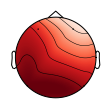

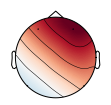

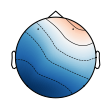

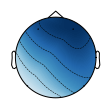

In [239]:
plot_maps(maps.T, primary_raw.info)

In [151]:
res  = primary_contaminated_data[primary_contaminated_data != 0]

In [38]:
AF7 = primary_power_45_70Hz[0,1:].mean(dtype='float')+1*primary_power_45_70Hz[0,1:].std(dtype='float')
AF7_thres = (AF7-primary_power_45_70Hz[0,1:].mean(dtype='float'))/(primary_power_45_70Hz[0,1:].std(dtype='float')) 
AF8 = np.median(primary_power_45_70Hz[1,1:],axis=None)+1*primary_power_45_70Hz[1,1:].std(dtype='float')
FT7 = np.median(primary_power_45_70Hz[2,1:],axis=None)+1*primary_power_45_70Hz[2,1:].std(dtype='float')
FT8 = np.median(primary_power_45_70Hz[3,1:],axis =None)+1*primary_power_45_70Hz[3,1:].std(dtype='float')
thres = [AF7,AF8,FT7,FT8]
thres

[45.331514132538615, 175.92448942576158, 143.3593005384753, 114.57697669477297]

In [ ]:
#Step 3: Locating the channels



#Step 3a: Decomposing the power data array into channels by epochs




#Step 4: Locating the contaminated epochs and finding the corresponding channel indices 
#for shuffling the contaminated data

In [242]:
# Looking for contaminated epochs in the adjacent channels
chan_epoch_indices_AF7 = np.zeros((len(AF7_raw.ch_names),100),dtype='int')
chan_epoch_indices_AF8 = np.zeros((len(AF8_raw.ch_names),100),dtype='int')
chan_epoch_indices_FT7 = np.zeros((len(FT7_raw.ch_names),100),dtype='int')
chan_epoch_indices_FT8 = np.zeros((len(FT8_raw.ch_names),100),dtype='int')


for chan,epoch in chan_epoch_indice_primary:
    if  chan_epoch_indice_primary.any(axis = None) == 0:
        for chan in range(len(AF7_raw.ch_names)):
            for epoch in range(50):
                if AF7_power_45_70Hz[chan,epoch] >threshold_val[0]:
                    chan_epoch_indices_AF7[chan,epoch] = epoch
    elif chan_epoch_indice_primary.any(axis = None) == 1:
        for chan in range(len(AF8_raw.ch_names)):
            for epoch in range(50):
                if AF8_power_45_70Hz[chan,epoch] >threshold_val[1]:
                    chan_epoch_indices_AF8[chan,epoch] = epoch
    elif chan_epoch_indice_primary.any(axis = None) == 2:
        for chan in range(len(FT7_raw.ch_names)):
            for epoch in range(50):
                if AF8_power_45_70Hz[chan,epoch] >threshold_val[2]:
                    chan_epoch_indices_FT7[chan,epoch] = epoch
    elif chan_epoch_indice_primary.any(axis = None) == 3:
        for chan in range(len(FT7_raw.ch_names)):
            for epoch in range(50):
                if AF8_power_45_70Hz[chan,epoch] >threshold_val[3]:
                    chan_epoch_indices_FT7[chan,epoch] = epoch
    
                
# Forming the contaminated data for each adjacent channels group



IndexError: index 8 is out of bounds for axis 0 with size 4

In [ ]:
 indices = [[],[],[],[]]
for chan in range(0,4):
    for epoch in range(50):
        nest_list= indices[chan]
        epcoh = list(set(chan_epoch_indice_primary[chan,1:]))
        nest_list.append(epoch)
    

In [88]:
contaminated_epoch_indice = set(chan_epoch_indice_primary[3,:])
list(contaminated_epoch_indice)[0]

0

In [59]:
chan_epoch_indices_AF8[0,15] 

15

In [56]:
data = AF8_raw.get_data()

In [64]:
a = data[4,1024*30:1024*31]

In [65]:
b = data[0,1024*15:1024*16]

In [75]:
contaminated_data = np.vstack((b,a))

In [78]:
contaminated_data[0,0:10]

array([-1.03660286e-05, -1.01354223e-05, -1.16820833e-05, -1.81384466e-05,
       -2.35010863e-05, -1.93317424e-05, -5.92173899e-06,  7.04538869e-06,
        1.17444811e-05,  1.06215013e-05])

### Calculation of power for combined data

#### Band power funnction: Based on the following formula:
Power_45_70Hz = (1/N**2) * sum{abs(X(k))**2 + abs(X(N-k))**2} from k = 45*(N/fs) to 70*(N/fs)

##### Reference paper:
    A Detection Scheme for Frontalis and Temporalis Muscle EMG Contamination of EEG Data
    Michael J. Fu∗, Janis J. Daly†, M. Cenk C¸ avus¸o˘glu‡ 
    ∗Department of Electrical Engineering and Computer Science, 
    Case Western Reserve University, Cleveland, Ohio 44106 Email: mjfu@case.edu
    †Department of Neurology, Case Western Reserve University School of Medicine, 
    Cleveland, Ohio 44106 Stroke Motor Control, Motor Laboratory, and FES Center of Excellence, 
    LSCDVA Medical Center, Cleveland Ohio 44106 Email: jjd17@case.edu 
    ‡Department of Electrical Engineering and Computer Science, Case Western Reserve University, 
    Cleveland, Ohio 44106Email: cavusoglu@case.edu

In [36]:
def band_power(data,N=1024,fs = 512,time_period = 2):
    
    data = data/1e-06 # Reducing the scale from volt to microvolts
    data = np.fft.fft(data, N)
    #calculation of k in the formula
    k_lower = int(45*(N/fs)) # Forcing these to integers otherwise index error problem will pop up 
    k_upper = int(70*(N/fs))
    temp = np.zeros((50),dtype='float')
    for k in range(k_lower, k_upper):
        val = (np.abs(data[k_lower])) ** 2 + (np.abs(data[N - k_lower])) ** 2
        temp[k-90] = val
        
    power_45_70Hz = (1/N**2)*sum(temp)
    return power_45_70Hz

In [35]:

fft_freq = np.fft.fftfreq(1024)


In [63]:
epochs_fft_theo_val = []
epochs_power_cross_check = np.zeros((24,50,50),dtype='float')
epochs_power_45_70Hz = np.zeros((24,50,50),dtype='float')


print('45-70 Hz frequncy band power of the 2s-EEG epochs of the EMG contaminated EEG channels\n\n')
for chan in range(combined_data.shape[0]):
    for epoch in range(50):
        print('Channel no: ',chan, 'Epoch_no: ',epoch)
        
        
        single_channel_data = combined_data[chan,1024*epoch:1024*(epoch+1)]
        #this can be an EEG epoch of 2 seconds
        #time_samples = list(map(int, np.linspace(1,1024,1024)))
        
        #Cross checks for power spectrum
        #Mean, Standard Deviation, and Variance of the single channel data
        mean_single_channel_data = np.mean(single_channel_data)
        std_single_channel_data = np.std(single_channel_data)
        var_single_channel_data = std_single_channel_data ** 2.0
        #print(' Mean value of channel data: ',mean_single_channel_data,'\n',
        #'Standard deviation: ',std_single_channel_data,'\n',Variance of channel data: ',
        #var_single_channel_data)
        epochs_power_cross_check[chan,epoch] = var_single_channel_data
        
        #Taking the fourier data
        #fft_data = np.fft.fft(single_channel_data,N = 1024)

        #Calculating the true theoretical values
        fft_theo = 2.0 * np.abs(fft_data/N)
        
        #Storing the theoretical values
        epochs_fft_theo_val.append(fft_theo)
        
        #Using the band_power function for 45-70 Hz frequency: See band_power function
        #N,fs = input('Please provide the total number of sample and the sampling frequency 
        #                    of the data')
        power_45_70Hz_band = band_power(single_channel_data,N = 1024,fs = 512)
        print('The 45-70 Hz frequncy band power of the epoch is : ',power_45_70Hz_band,'\n')
        epochs_power_45_70Hz[chan,epoch] = power_45_70Hz_band
       
        

45-70 Hz frequncy band power of the 2s-EEG epochs of the EMG contaminated EEG channels


Channel no:  0 Epoch_no:  0
The 45-70 Hz frequncy band power of the epoch is :  1.2248943884020055e-14 

Channel no:  1 Epoch_no:  0
The 45-70 Hz frequncy band power of the epoch is :  1.78317808496035e-14 

Channel no:  2 Epoch_no:  0
The 45-70 Hz frequncy band power of the epoch is :  1.5472336886095632e-12 

Channel no:  3 Epoch_no:  0
The 45-70 Hz frequncy band power of the epoch is :  2.3077807807760838e-15 

Channel no:  4 Epoch_no:  0
The 45-70 Hz frequncy band power of the epoch is :  7.589269381890737e-14 

Channel no:  5 Epoch_no:  0
The 45-70 Hz frequncy band power of the epoch is :  2.447559443654897e-14 

Channel no:  6 Epoch_no:  0
The 45-70 Hz frequncy band power of the epoch is :  2.2101392535738227e-16 

Channel no:  7 Epoch_no:  0
The 45-70 Hz frequncy band power of the epoch is :  1.0919530619739173e-14 

Channel no:  8 Epoch_no:  0
The 45-70 Hz frequncy band power of the epoch i

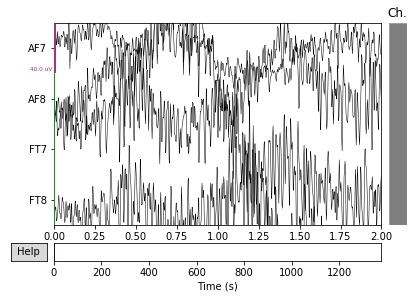

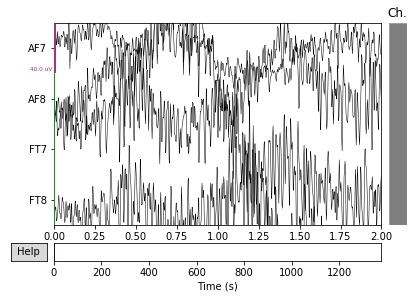

In [42]:
primary_raw.plot(duration= 2.0,title = 'Primary channels', n_channels = len(primary_raw.ch_names),
                 show=True)

# Plotting of the power spectral density in the frequency band of 45-70 Hz



Plotting the primary electrodes(channels) power spectral density within 45-70Hz frequency band  


Effective window size : 2.000 (s)


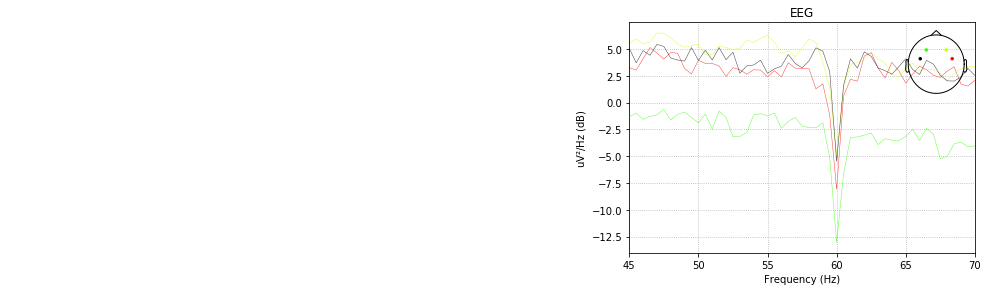

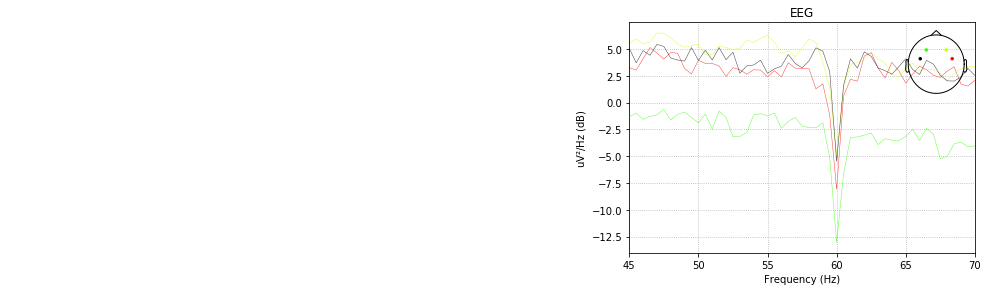

In [30]:
primary_raw.plot_psd(fmin=45.0, fmax= 70.0, tmin=0.0, tmax=100.0, proj=False, n_fft= 512*2, 
             n_overlap= 0, reject_by_annotation=True, picks=primary_picks, ax=None, color='black', 
             xscale='linear', area_mode='std', area_alpha=0.33, dB=True, estimate='power', 
             show=True, n_jobs=1, average=False, line_alpha=None, spatial_colors=True, verbose=None)


In [46]:
#Setting the time points eeg epochs of 2 seconds 
tmin = list(map(int, np.linspace(0,250,100)))
tmax = list(map(int, np.linspace(2,252,100)))

Epoch number:  0 
PSD for the primary channeles
Effective window size : 2.000 (s)


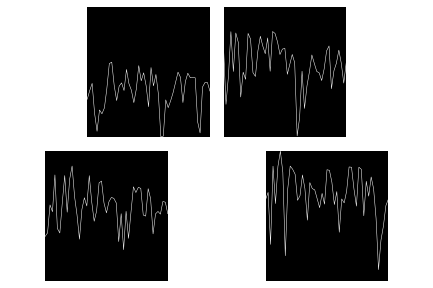

Epoch number:  1 
PSD for the primary channeles
Effective window size : 2.000 (s)


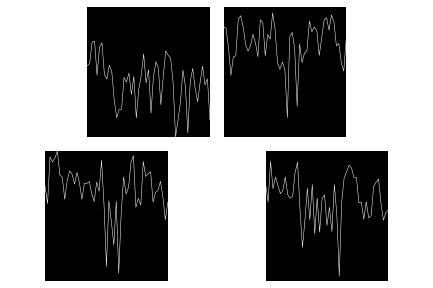

Epoch number:  2 
PSD for the primary channeles
Effective window size : 2.000 (s)


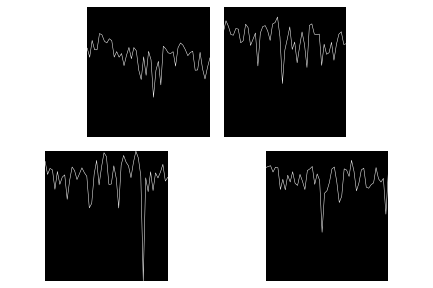

Epoch number:  3 
PSD for the primary channeles
Effective window size : 2.000 (s)


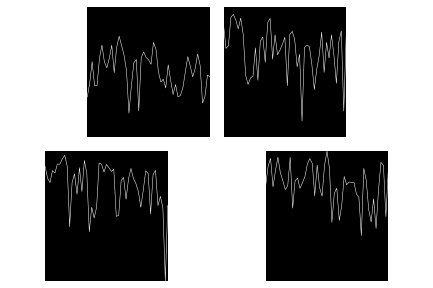

Epoch number:  4 
PSD for the primary channeles
Effective window size : 2.000 (s)


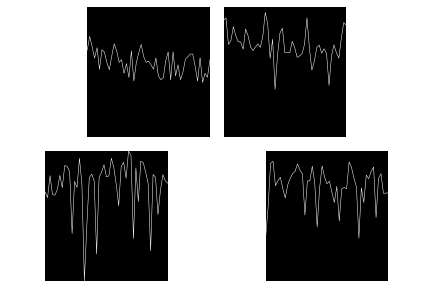

In [33]:
#Plotting the topographics of the PSD of first 5 eeg peochs 2 seconds interval for demonstration 
for i in range(5):
    epoch_num = i
    print('Epoch number: ',epoch_num,'\nPSD for the primary channeles')
    primary_raw.plot_psd_topo(tmin = tmin[i], tmax = tmax[i], fmin= 45, fmax= 70, proj=False, 
                  n_fft= 1024, n_overlap=0, layout=None, color='w', fig_facecolor='w', 
                  axis_facecolor='k', dB=True, show=True, block=False, n_jobs=1, axes=None, 
                  verbose=None)

Plotting the 5 adjacent channels of the primary channel: AF7.

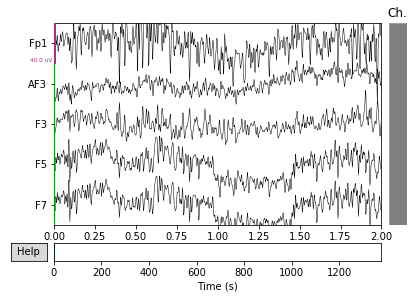

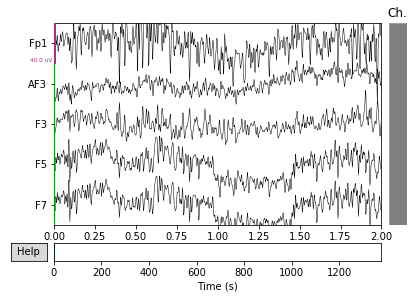

In [54]:
AF7_raw.plot(duration= 2.0,title = 'The 5 adjacent channels of the channel "AF7"', 
             n_channels = len(AF7_raw.ch_names),show=True)

Epoch number:  0 
PSD for the 5 adjacent channels of the channel "AF7"
Effective window size : 2.000 (s)


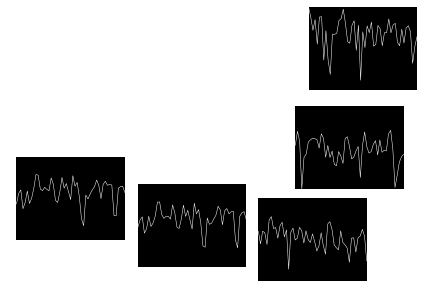

Epoch number:  1 
PSD for the 5 adjacent channels of the channel "AF7"
Effective window size : 2.000 (s)


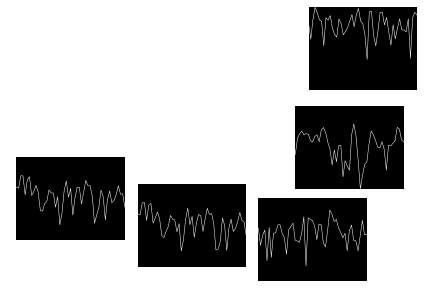

Epoch number:  2 
PSD for the 5 adjacent channels of the channel "AF7"
Effective window size : 2.000 (s)


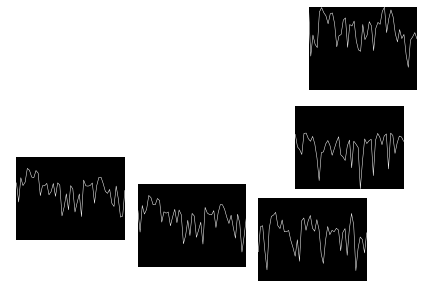

Epoch number:  3 
PSD for the 5 adjacent channels of the channel "AF7"
Effective window size : 2.000 (s)


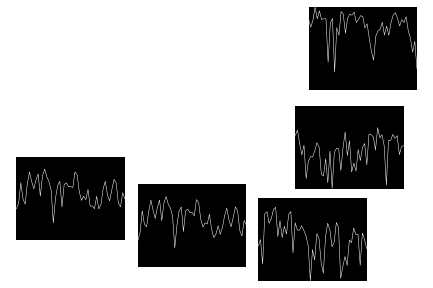

Epoch number:  4 
PSD for the 5 adjacent channels of the channel "AF7"
Effective window size : 2.000 (s)


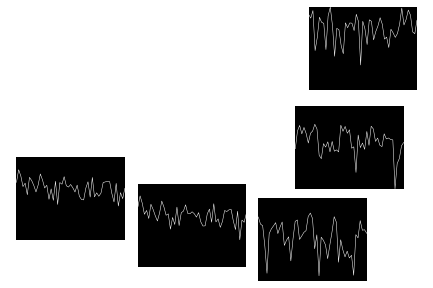

In [55]:
for i in range(5):
    epoch_num = i
    print('Epoch number: ', epoch_num,'\nPSD for the 5 adjacent channels of the channel "AF7"')
    AF7_raw.plot_psd_topo(tmin = tmin[i], tmax = tmax[i], fmin= 45, fmax= 70, proj=False, 
                  n_fft= 1024, n_overlap=0, layout=None, color='w', fig_facecolor='w', 
                  axis_facecolor='k', dB=True, show=True, block=False, n_jobs=1, axes=None, 
                  verbose=None)   

Plotting the 5 adjacent channels of the primary channel: AF8.

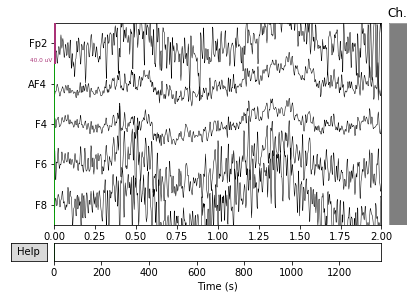

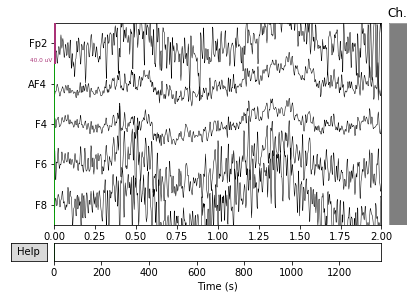

In [44]:
AF8_raw.plot(duration= 2.0,title = 'The 5 adjacent channels of the channel "AF8"', 
             n_channels = len(AF8_raw.ch_names),show=True)

Epoch number:  0 
PSD for the 5 adjacent channels of the channel "AF8"
Effective window size : 2.000 (s)


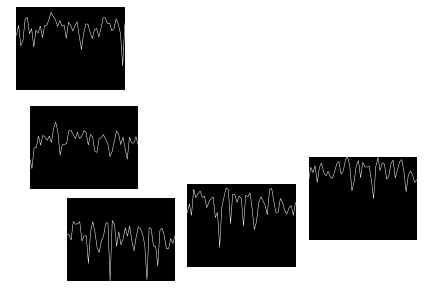

Epoch number:  1 
PSD for the 5 adjacent channels of the channel "AF8"
Effective window size : 2.000 (s)


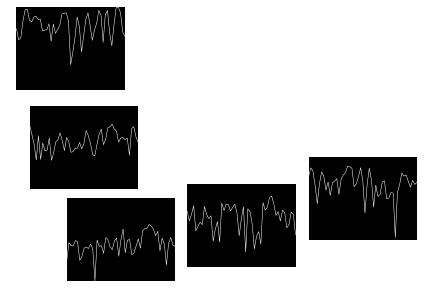

Epoch number:  2 
PSD for the 5 adjacent channels of the channel "AF8"
Effective window size : 2.000 (s)


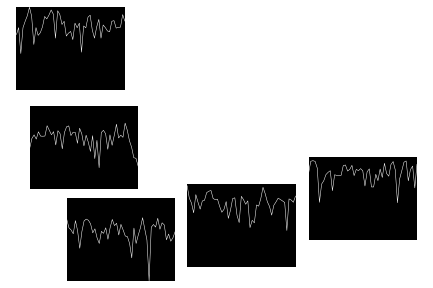

Epoch number:  3 
PSD for the 5 adjacent channels of the channel "AF8"
Effective window size : 2.000 (s)


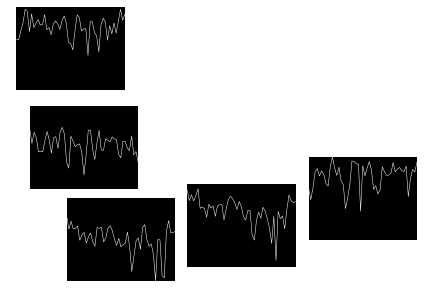

Epoch number:  4 
PSD for the 5 adjacent channels of the channel "AF8"
Effective window size : 2.000 (s)


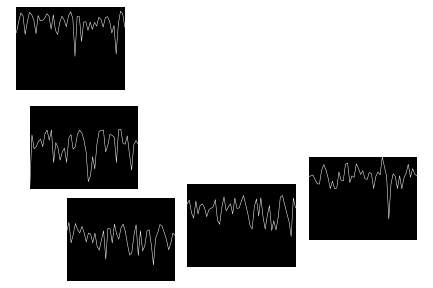

In [56]:
for i in range(5):
    epoch_num = i
    print('Epoch number: ', epoch_num,'\nPSD for the 5 adjacent channels of the channel "AF8"')
    AF8_raw.plot_psd_topo(tmin = tmin[i], tmax = tmax[i], fmin= 45, fmax= 70, proj=False, 
                  n_fft= 1024, n_overlap=0, layout=None, color='w', fig_facecolor='w', 
                  axis_facecolor='k', dB=True, show=True, block=False, n_jobs=1, axes=None, 
                  verbose=None)

Plotting the 5 adjacent channels of the primary channel: FT7.

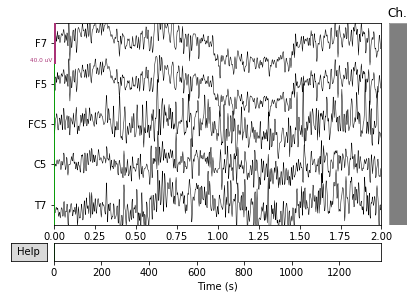

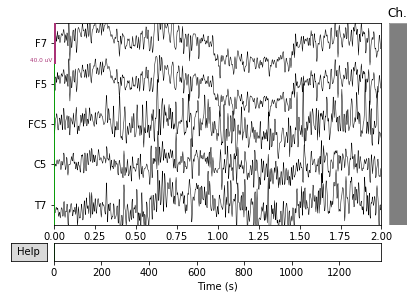

In [45]:
FT7_raw.plot(duration= 2.0,title = 'The 5 adjacent channels of the channel "FT7"', 
             n_channels = len(FT7_raw.ch_names),show=True)

Epoch number:  0 
PSD for the 5 adjacent channels of the channel "FT7"
Effective window size : 2.000 (s)


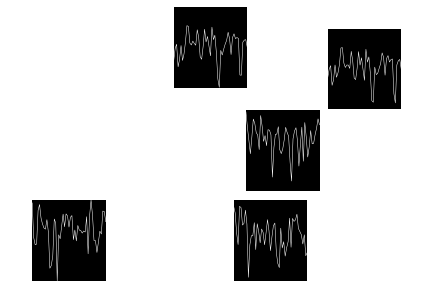

Epoch number:  1 
PSD for the 5 adjacent channels of the channel "FT7"
Effective window size : 2.000 (s)


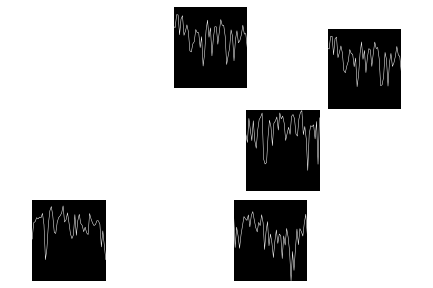

Epoch number:  2 
PSD for the 5 adjacent channels of the channel "FT7"
Effective window size : 2.000 (s)


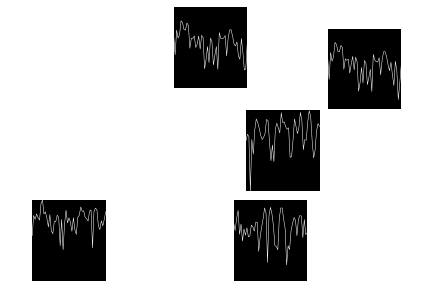

Epoch number:  3 
PSD for the 5 adjacent channels of the channel "FT7"
Effective window size : 2.000 (s)


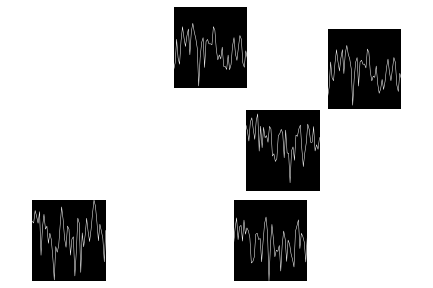

Epoch number:  4 
PSD for the 5 adjacent channels of the channel "FT7"
Effective window size : 2.000 (s)


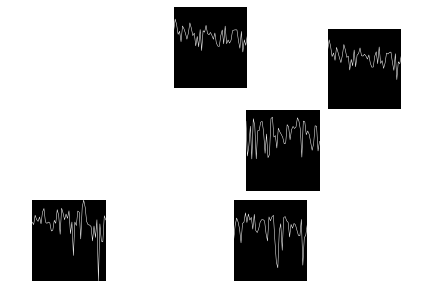

In [57]:
for i in range(5):
    epoch_num = i
    print('Epoch number: ', epoch_num,'\nPSD for the 5 adjacent channels of the channel "FT7"')
    FT7_raw.plot_psd_topo(tmin = tmin[i], tmax = tmax[i], fmin= 45, fmax= 70, proj=False, 
                  n_fft= 1024, n_overlap=0, layout=None, color='w', fig_facecolor='w', 
                  axis_facecolor='k', dB=True, show=True, block=False, n_jobs=1, axes=None, 
                  verbose=None)

Plotting the 5 adjacent channels of the primary channel: FT8.

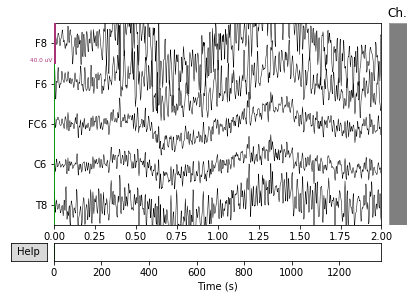

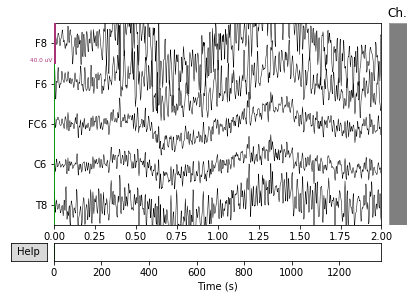

In [46]:
FT8_raw.plot(duration= 2.0,title = 'The 5 adjacent channels of the channel "FT8"', 
             n_channels = len(FT8_raw.ch_names),show=True)

Epoch number:  0 
PSD for the 5 adjacent channels of the channel "FT8"
Effective window size : 2.000 (s)


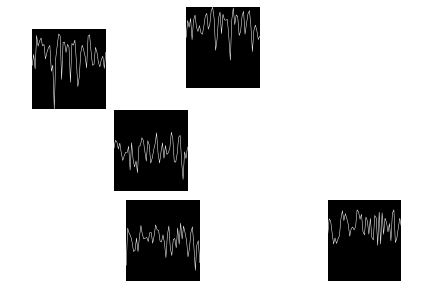

Epoch number:  1 
PSD for the 5 adjacent channels of the channel "FT8"
Effective window size : 2.000 (s)


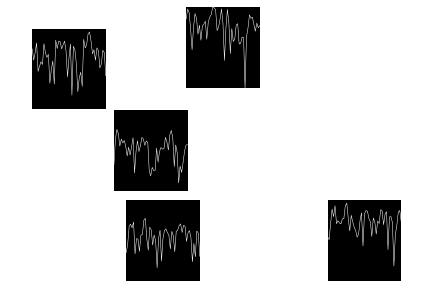

Epoch number:  2 
PSD for the 5 adjacent channels of the channel "FT8"
Effective window size : 2.000 (s)


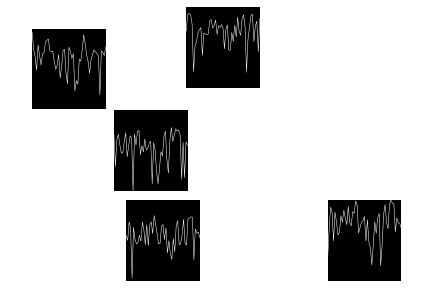

Epoch number:  3 
PSD for the 5 adjacent channels of the channel "FT8"
Effective window size : 2.000 (s)


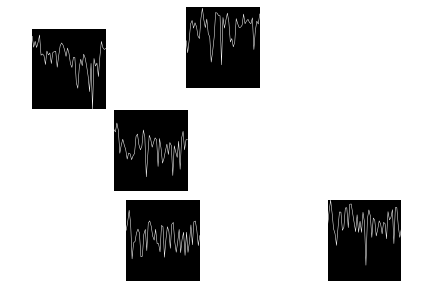

Epoch number:  4 
PSD for the 5 adjacent channels of the channel "FT8"
Effective window size : 2.000 (s)


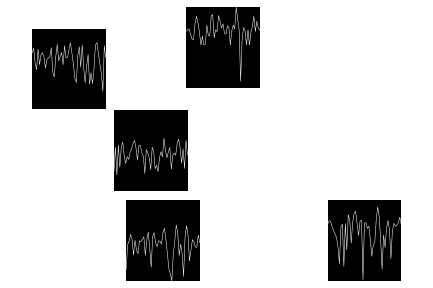

In [59]:
for i in range(5):
    epoch_num = i
    print('Epoch number: ', epoch_num,'\nPSD for the 5 adjacent channels of the channel "FT8"')
    FT8_raw.plot_psd_topo(tmin = tmin[i], tmax = tmax[i], fmin= 45, fmax= 70, proj=False, 
                  n_fft= 1024, n_overlap=0, layout=None, color='w', fig_facecolor='w', 
                  axis_facecolor='k', dB=True, show=True, block=False, n_jobs=1, axes=None, 
                  verbose=None)

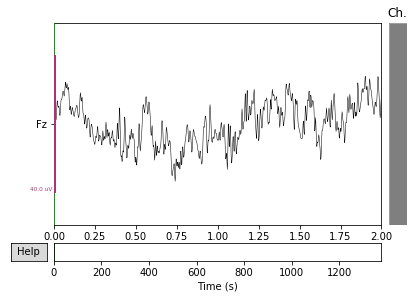

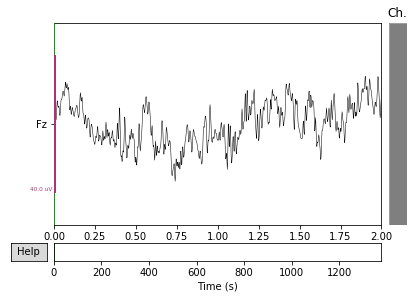

In [44]:
Fz_raw.plot(duration= 2.0,title = 'The channel "Fz" between the primary channels', 
             n_channels = len(Fz_raw.ch_names),show=True)

In [51]:
Fz_data.shape

(1, 705536)

In [99]:
Fz_power_45_70Hz = final_band_power(raw, channel = Fz_picks, N=1024,fs=512) 

Plotting of the data for a time window of 2 seconds

array([5.16287015e-13])

In [11]:
N = 1024 #1024 points
Lx = 2 #Time period
fft_freq = np.fft.fftfreq(N)# setting the fourier frequencies


mask = fft_freq > 0# Masking half values that is the negative frequencies 
#as they are complex conjugate

#wave numbers - number of waves the signal needs to occupy the domain
#No of waves per domain length
nwaves = fft_freq * N

#Creating all necessary time periods (or distances)
times = 1.0/fft_freq
times[fft_freq == 0] = Lx

#Taking the fourier data
fft_data = np.fft.fft(single_channel_data)

#Calculating the theoretical values
fft_theo = 2.0*np.abs(fft_data/N)

C:\Users\J_CHOWD\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


In [266]:
#This is power spectra
ps = 2.0* (np.abs(fft_data/N) ** 2)

#Power by varience 
pow_var = (ps/var_single_channel_data)*100.0

#Freq.power spectra - for varience preserving form
fps = ps * fft_freq
#Sum of power spectra values
print('Sum of power spectra values: ',sum(ps[mask]))

Sum of power spectra values:  6.122573346226504e-11


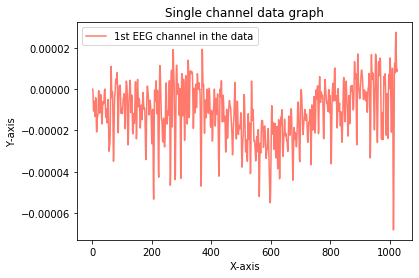

In [239]:
plt.figure(1)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Single channel data graph")
plt.plot(time_samples,single_channel_data,color = 'xkcd:salmon',label = '1st EEG channel in the data')
plt.legend()
plt.show()

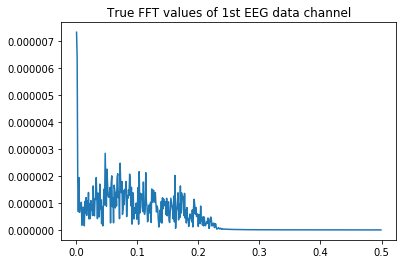

In [240]:
#Plotting the real values of the fast fourier data
plt.figure(2)
#plt.plot(fft_freq,fft_data,label = 'Raw FFT values')
#plt.title('Raw FFT values - need more processing')
plt.plot(fft_freq[mask],fft_theo[mask], label = 'True FFT values')
plt.title("True FFT values of 1st EEG data channel")
plt.show()

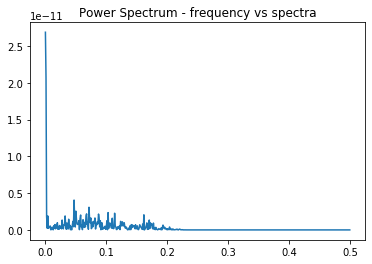

In [241]:
plt.figure(3)
plt.plot(fft_freq[mask],ps[mask], label = 'frequency vs spectra')
plt.title("Power Spectrum - frequency vs spectra")
plt.show()

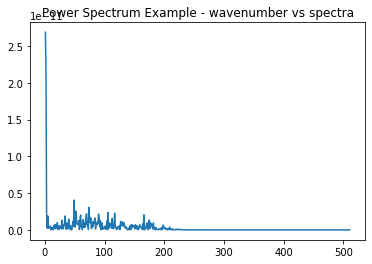

In [242]:
plt.figure(4)
plt.plot(nwaves[mask],ps[mask],label ='wavenumber vs spectra')
plt.title('Power Spectrum Example - wavenumber vs spectra')
plt.show()

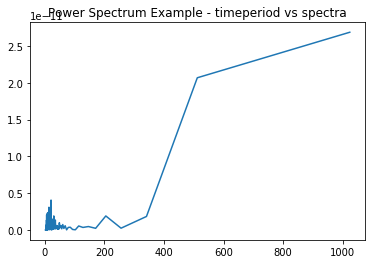

In [243]:
plt.figure(5)
plt.plot(times[mask],ps[mask],label ='timeperiod vs spectra')
plt.title('Power Spectrum Example - timeperiod vs spectra')
plt.show()

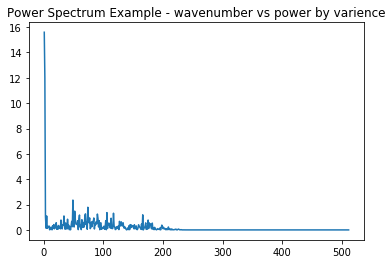

In [245]:
plt.figure(6)
plt.plot(nwaves[mask],pow_var[mask],label ='wavenumber vs power by varience')
plt.title('Power Spectrum Example - wavenumber vs power by varience')
plt.show()

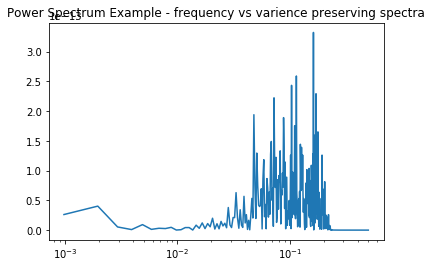

In [247]:
plt.figure(7)
plt.semilogx(fft_freq[mask],fps[mask],label ='frequency vs varience preserving spectra')
plt.title('Power Spectrum Example - frequency vs varience preserving spectra')
plt.show()